## Loading the SBERT Embeddings and passing them in the GP model


In [1]:
from sentence_transformers import SentenceTransformer, util
import pickle
import torch
import numpy as np
import pandas as pd
import gpytorch
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Model for computing sentence embeddings. We use one trained for similar questions detection
model = SentenceTransformer("all-MiniLM-L6-v2")


In [2]:
class GPLVMModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super().__init__(variational_strategy)

        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def train_gplvm(X, latent_dim=2, n_inducing=30, num_iter=300):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Use SVD-based PCA to initialize latent space
    U, S, V = torch.pca_lowrank(X, q=latent_dim)
    Z_init = X @ V[:, :latent_dim]
    Z_init = Z_init.to(device)

    # Target: only one dimension for now (1D regression problem)
    y = X[:, 0].to(device)

    # Define inducing points
    inducing_points = Z_init[:n_inducing]

    # Model
    model = GPLVMModel(inducing_points).to(device)
    likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)

    model.train()
    likelihood.train()

    optimizer = torch.optim.Adam([
        {'params': model.parameters()},
        {'params': likelihood.parameters()},
    ], lr=0.01)

    mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=y.size(0))

    for i in range(num_iter):
        optimizer.zero_grad()
        output = model(Z_init)
        loss = -mll(output, y)
        loss.backward()
        if i % 50 == 0:
            print(f"Iter {i}: loss = {loss.item():.4f}")
        optimizer.step()

    return model, likelihood, Z_init, y



In [3]:

with open ('../full_data.pkl', 'rb') as f:
    data = pickle.load(f)
    print(type(data))
    data = pd.DataFrame(data)
    


<class 'dict'>


In [4]:
# Index(['DeepSeek-R1-Distill-Qwen-1.5B', 'gemma-3-1b-it', 'Llama-3.2-1B'], dtype='object')
model_name = "DeepSeek-R1-Distill-Qwen-1.5B"

dataset_name = 'trivia_qa'

corpus_sentences = data[model_name][dataset_name]['answers'][0]

corpus_embeds = model.encode(corpus_sentences, batch_size=64, show_progress_bar=True, convert_to_tensor=True)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
print(corpus_embeds.shape)

torch.Size([20, 384])


In [6]:
# Assume X is your (n_samples, embedding_dim) tensor
new_model, new_likelihood, new_Z_latent, new_y_obs = train_gplvm(corpus_embeds, latent_dim=2, n_inducing=3, num_iter=100)

Iter 0: loss = 1.2399
Iter 50: loss = 0.6630


## Visuals

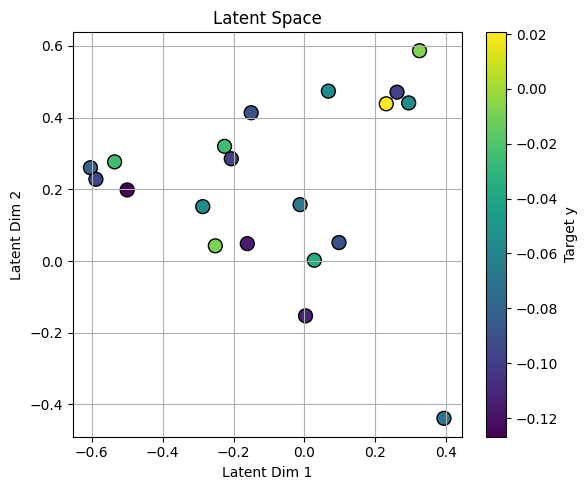

In [7]:
def plot_latent_space_torch(Z, y, title='Latent Space'):
    Z = Z.detach().cpu()
    y = y.detach().cpu()

    plt.figure(figsize=(6, 5))
    scatter = plt.scatter(Z[:, 0], Z[:, 1], c=y, cmap='viridis', s=100, edgecolors='k')
    plt.colorbar(scatter, label='Target y')
    plt.title(title)
    plt.xlabel('Latent Dim 1')
    plt.ylabel('Latent Dim 2')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_latent_space_torch(new_Z_latent, new_y_obs)

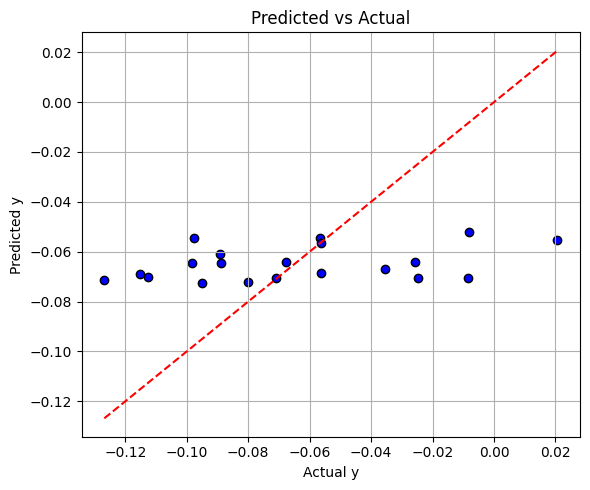

In [8]:
def plot_predictions(model, likelihood, Z, y_true):
    model.eval()
    likelihood.eval()

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        preds = likelihood(model(Z))
        y_pred = preds.mean

    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().numpy()

    plt.figure(figsize=(6, 5))
    plt.scatter(y_true, y_pred, c='blue', edgecolors='k')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel('Actual y')
    plt.ylabel('Predicted y')
    plt.title('Predicted vs Actual')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_predictions(new_model, new_likelihood, new_Z_latent, new_y_obs)


In [10]:
from sklearn.metrics import mean_squared_error, r2_score

def evaluate_model(model, likelihood, Z, y_true):
    model.eval()
    likelihood.eval()

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        preds = likelihood(model(Z))
        y_pred = preds.mean

    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().numpy()

    rmse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"RMSE: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")

evaluate_model(new_model, new_likelihood, new_Z_latent, new_y_obs)



RMSE: 0.0014
R² Score: 0.0934


## Statistics

In [11]:
def check_latent_space(Z, y):
    Z = Z.detach().cpu()
    y = y.detach().cpu()
    print("Latent space shape:", Z.shape)
    print("y shape:", y.shape)
    print("First 5 points in latent space and their y values:")
    for i in range(min(5, Z.size(0))):
        print(f"Z[{i}]: {Z[i].tolist()} → y: {y[i].item():.4f}")

check_latent_space(new_Z_latent, new_y_obs)


Latent space shape: torch.Size([20, 2])
y shape: torch.Size([20])
First 5 points in latent space and their y values:
Z[0]: [-0.5356570482254028, 0.27671879529953003] → y: -0.0247
Z[1]: [0.02790777198970318, 0.00232870876789093] → y: -0.0354
Z[2]: [0.29409071803092957, 0.4411056339740753] → y: -0.0565
Z[3]: [-0.15034377574920654, 0.41370660066604614] → y: -0.0891
Z[4]: [0.393557071685791, -0.43864917755126953] → y: -0.0708


In [12]:
def check_predictions(model, likelihood, Z, y_true):
    model.eval()
    likelihood.eval()

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        preds = likelihood(model(Z))
        y_pred = preds.mean

    y_true = y_true.detach().cpu()
    y_pred = y_pred.detach().cpu()

    print("First few predictions:")
    for i in range(min(5, y_true.shape[0])):
        print(f"True: {y_true[i].item():.4f} — Predicted: {y_pred[i].item():.4f}")

check_predictions(new_model, new_likelihood, new_Z_latent, new_y_obs)

First few predictions:
True: -0.0247 — Predicted: -0.0705
True: -0.0354 — Predicted: -0.0667
True: -0.0565 — Predicted: -0.0547
True: -0.0891 — Predicted: -0.0610
True: -0.0708 — Predicted: -0.0703
